In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:6], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte'], 32033)

In [3]:
letters = sorted(list(set("".join(words))))
letters[:10]

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']

In [4]:
ltoi = { l:i + 1 for i,l in enumerate(letters)}
ltoi["."] = 0
itol = { i+1:l for i,l in enumerate(letters)}
itol[0] = "."
ltoi

{'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26,
 '.': 0}

In [5]:
block_size = 3;

def bulid_dataset(words, show_steps = False):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for l in w + ".":
            idx = ltoi[l]
            X.append(context)
            Y.append(idx)
            
            if(show_steps):
                print(''.join(itol[i] for i in context), '--->', itol[idx])
            context = context[1:] + [idx]
    return torch.tensor(X), torch.tensor(Y)

Xsample, Ysample = bulid_dataset(words[:1], True)
print("X : ", Xsample.tolist())
print("Y : ", Ysample.tolist())

... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
X :  [[0, 0, 0], [0, 0, 5], [0, 5, 13], [5, 13, 13], [13, 13, 1]]
Y :  [5, 13, 13, 1, 0]


In [7]:
import random
random.seed(42)
random.shuffle(words)

# train => 80%, validation => 10%, test => 10% 
n1 = int(len(words) * 0.8)
n2 = int(len(words) * 0.9)

Xtrain, Ytrain = bulid_dataset(words[ : n1])
Xval   , Yval  = bulid_dataset(words[n1 : n2])
Xtest  , Ytest = bulid_dataset(words[n2 : ])
print("train : ", len(Xtrain))
print("val : ", len(Xval))
print("test: ", len(Xtest))

train :  182580
val :  22767
test:  22799


The implementing model will be similar as:
[Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
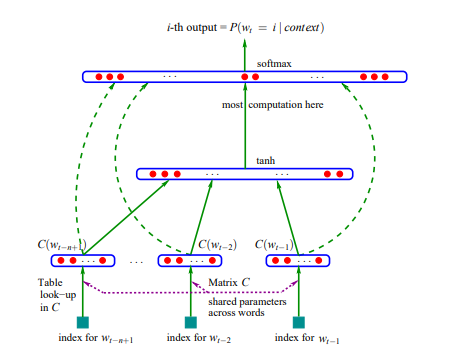

In [8]:
# hyper parameters
c_dim = 10
hidden_size = 200 

letters_len = len(ltoi) # 27
g  = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((letters_len, c_dim), generator=g)
W1 = torch.randn((c_dim * block_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)
W2 = torch.randn((hidden_size, letters_len), generator=g)
b2 = torch.randn(letters_len, generator=g)
parameters = [C, W1, b1, W2, b2]

In [9]:
for p in parameters:
  p.requires_grad = True
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [10]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

lri = []
lossi = []
stepi = []

In [11]:
for i in range(200000):
    
    idx = torch.randint(0, Xtrain.shape[0], (32,))
    
    # forward pass
    emb = C[Xtrain[idx]] # (32, block_size, c_dim)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, hidden_size)
    logits = h @ W2 + b2 # (32, letters_len = 27)
    loss = F.cross_entropy(logits, Ytrain[idx])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    #lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    #lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())


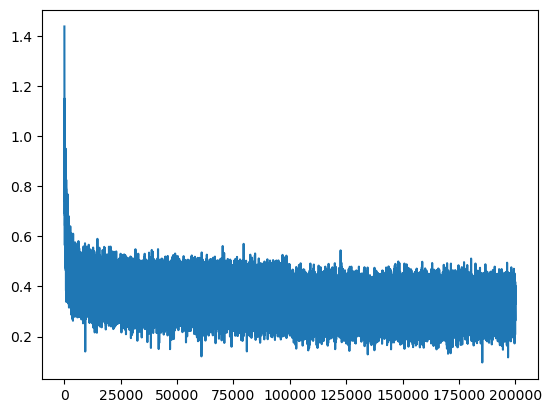

In [12]:
plt.plot(stepi, lossi)

In [13]:
# training loss 
emb = C[Xtrain] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytrain)
loss

tensor(2.1285, grad_fn=<NllLossBackward0>)

In [14]:
# validation loss
emb = C[Xval] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yval)
loss

tensor(2.1682, grad_fn=<NllLossBackward0>)

In [15]:
# test loss
emb = C[Xtest] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytest)
loss

tensor(2.1740, grad_fn=<NllLossBackward0>)

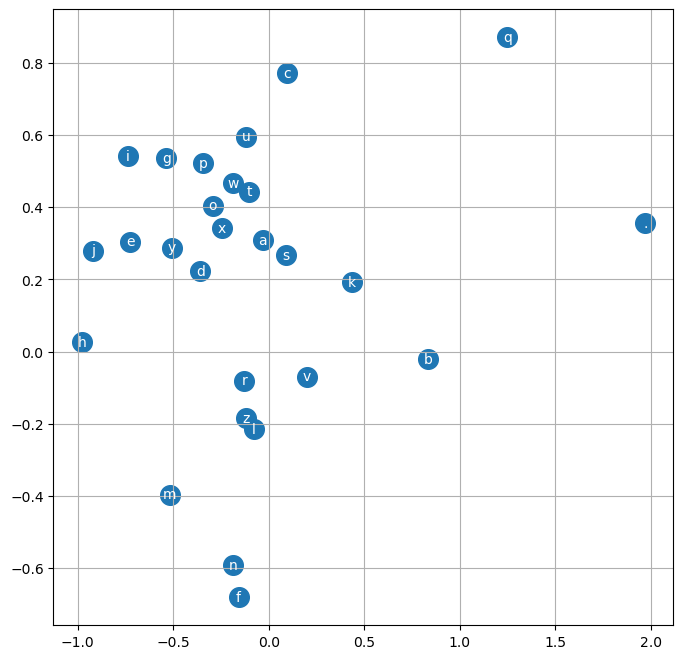

In [16]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itol[i], ha="center", va="center", color='white')
plt.grid('minor')

In [17]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itol[i] for i in out))

mora.
mayah.
see.
med.
rylle.
emmastendraeg.
azeredielin.
shi.
jenleigh.
lan.
narielleigh.
kalin.
shubergahiriel.
kin.
renlynn.
nopudrius.
macder.
yarleyels.
kay.
muston.
